# Курсовой проект студента GeekBrains
# Автор: Ельцов Артем Александрович
# Ник на kaggle: virus_madison

# Задание для курсового проекта
# Метрика: R2 - коэффициент детерминации (sklearn.metrics.r2_score)

*Сдача проекта:*

Соревнование заканчивается 10.01.21
Прислать в раздел Задания Урока 10 ("Вебинар. Консультация по итоговому проекту") ссылку на ноутбук в github или public kaggle notebook.
Необходимо получить R2 > 0.6 на Private Leaderboard.
Укажите свой ник на kaggle
Примечание: Все файлы csv должны содержать названия полей (header - то есть "шапку"), разделитель - запятая. В файлах не должны содержаться индексы из датафрейма.

*Рекомендации для файла с кодом (ipynb):*

Файл должен содержать заголовки и комментарии
Повторяющиеся операции лучше оформлять в виде функций
По возможности добавлять графики, описывающие данные (около 3-5)
Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
Весь проект должен быть в одном скрипте (файл ipynb).
При использовании статистик (среднее, медиана и т.д.) в качестве признаков, лучше считать их на трейне, и потом на валидационных и тестовых данных не считать статистики заново, а брать их с трейна.
Проект должен полностью отрабатывать за разумное время (не больше 10 минут), поэтому в финальный вариант лучше не включать GridSearch с перебором большого количества сочетаний параметров.

In [1004]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/real-estate-price-prediction-moscow/sample_submission.csv
/kaggle/input/real-estate-price-prediction-moscow/train.csv
/kaggle/input/real-estate-price-prediction-moscow/test.csv


In [1005]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

**# **Стандартизируем стиль вывода данных****

In [1006]:
matplotlib.rcParams.update({'font.size': 14})

# Получим пути к директориям с файлами

In [1007]:
TRAIN_DATASET_PATH = '/kaggle/input/real-estate-price-prediction-moscow/train.csv'
TEST_DATASET_PATH = '/kaggle/input/real-estate-price-prediction-moscow/test.csv'

# **Прочитаем данные из дата сетов, возьмём из них верхние 5 строчек, дадим дата сетам имена и посмортим какие типы данных в них.**

In [1008]:
train_df = pd.read_csv(TRAIN_DATASET_PATH, sep=',')
train_df.name = 'Train data frame'
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.102962


In [1009]:
train_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [1010]:
test_df = pd.read_csv(TEST_DATASET_PATH, sep=',')
test_df.name = 'Test data frame'
test_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,4567,44,1.0,36.847630,19.094182,5.0,5,9.0,1970,0.036122,B,B,24,4378,0,1036.0,1,1,B
1,5925,62,1.0,42.493907,42.568133,10.0,7,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A
2,960,27,2.0,59.463678,NaN,9.0,19,19.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B
3,3848,23,3.0,49.646030,33.893825,6.0,2,2.0,1965,0.014073,B,B,2,475,0,NaN,0,0,B
4,746,74,1.0,53.837056,NaN,1.0,8,17.0,1977,0.309479,B,B,35,7715,4,990.0,0,6,B


In [1011]:
test_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
dtype: object

# С помощью процедуры оптимизатора используемой памяти попробуем уменьшить расход памяти

In [1012]:
def memory_compression(df):
    original_mem = df.memory_usage().sum()/1024**2
    
    for col in df.columns:
        
        if df[col].dtype != object:
            col_min = df[col].min()
            col_max = df[col].max()

            if str(df[col].dtype)[:3] == 'int':
                if col_min > np.iinfo(np.int8).min and col_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif col_min > np.iinfo(np.int16).min and col_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif col_min > np.iinfo(np.int32).min and col_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif col_min > np.iinfo(np.int64).min and col_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            elif str(df[col].dtype)[:5] == 'float':
                if col_min > np.finfo(np.float32).min and col_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')
            
    reduced_mem = df.memory_usage().sum()/1024**2
    
    print(f'Изначальный размер занимаемой памяти в {df.name} равен {round(original_mem,2)} мб.')
    print(f'Конечный размер занимаемой памяти в {df.name} равен {round(reduced_mem,2)} мб.')

In [1013]:
memory_compression(train_df)
memory_compression(test_df)

Изначальный размер занимаемой памяти в Train data frame равен 1.53 мб.
Конечный размер занимаемой памяти в Train data frame равен 0.49 мб.
Изначальный размер занимаемой памяти в Test data frame равен 0.72 мб.
Конечный размер занимаемой памяти в Test data frame равен 0.21 мб.


Загрузка данных

**Описание датасета**

* Id - идентификационный номер квартиры
* DistrictId - идентификационный номер района
* Rooms - количество комнат в квартире
* Square - площадь квартры
* LifeSquare - жилая площадь
* KitchenSquare - площадь кухни
* Floor - этаж на котором находится квартира
* HouseFloor - количество этажей в доме
* HouseYear - год постройки дома
* Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности
* Social_1, Social_2, Social_3 - социальные показатели местности
* Healthcare_1, Helthcare_2 - развитость местности в плане здравоохранения
* Shops_1, Shops_2 - показатели, связанные с наличием близлижащих магазинов,торговых центров
* Price - цена квартиры

In [1014]:
print('Строк в тренеровочном дата сете:', train_df.shape[0])
print('Строк в тестововм дата сете', test_df.shape[0])

Строк в тренеровочном дата сете: 10000
Строк в тестововм дата сете 5000


Посмотрим различаются ли два дата сета только наличием одной колонки Price или нет.

In [1015]:
train_df.shape[1] - 1 == test_df.shape[1]

True

# Приведение типов

In [1016]:
train_df.dtypes

Id                  int16
DistrictId          int16
Rooms             float32
Square            float32
LifeSquare        float32
KitchenSquare     float32
Floor                int8
HouseFloor        float32
HouseYear           int32
Ecology_1         float32
Ecology_2        category
Ecology_3        category
Social_1             int8
Social_2            int16
Social_3            int16
Healthcare_1      float32
Helthcare_2          int8
Shops_1              int8
Shops_2          category
Price             float32
dtype: object

Объектные типы данных в дата сетах изменились на category. Сеты стали весить чуть легче и стали немного удобней в плане работы с их элементами.

In [1017]:
# Так как Id это уникальный идентификатор для всех наблюдений, то сменим для подобных колонок тип данных на str
train_df['Id'] = train_df['Id'].astype(str)
train_df['DistrictId'] = train_df['DistrictId'].astype(str)

# **1. EDA**
# **Делаем EDA для:**
 
* Исправления выбросов
* Заполнения NaN
* Идей для генерации новых фич
* Целевая переменная

Возьмём цену из тренировочного дата сета и изобразим гистаграмму зависимости цены от количества значений

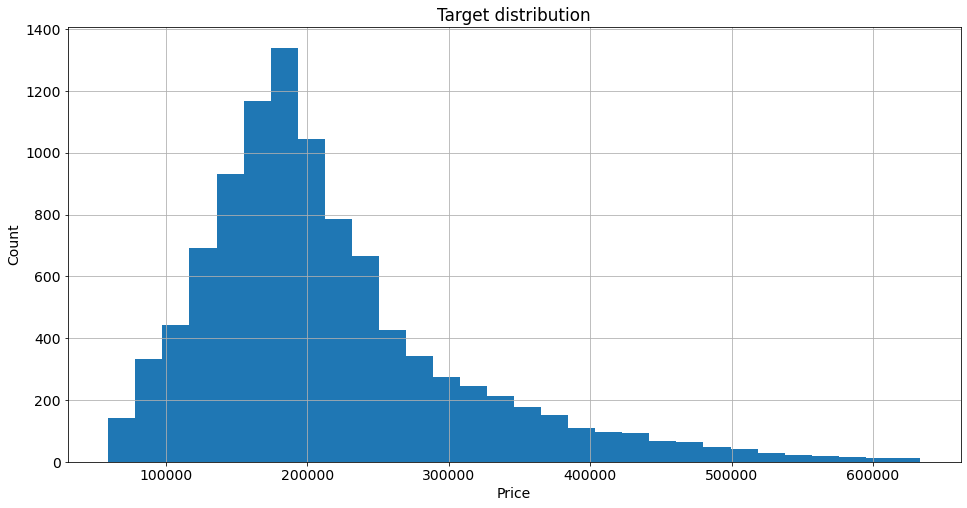

In [1018]:
plt.figure(figsize = (16, 8))

train_df['Price'].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('Price')

plt.title('Target distribution')
plt.show()

**Количественные переменные**

In [1019]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.0000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315720,37.199665,6.273300,8.526700,12.6094,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904419,1.319500,4.231300,214138.937500
std,0.839522,21.058716,86.241219,28.560839,5.241148,6.7762,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.519470,1.493601,4.806341,92872.273438
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.0000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.777344
25%,1.000000,41.774879,22.769833,1.000000,4.000000,9.0000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.628906
50%,2.000000,52.513309,32.781261,6.000000,7.000000,13.0000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.648438
75%,2.000000,65.900627,45.128803,9.000000,12.000000,17.0000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.460938
max,19.000000,641.065186,7480.592285,2014.000000,42.000000,117.0000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.437500


Судя по колонкам и по количеству строк, в колонках: LifeSquare, Helthcare_1 есть пропуски строк которые нужно будет заполнять.

In [1020]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             10000 non-null  object  
 1   DistrictId     10000 non-null  object  
 2   Rooms          10000 non-null  float32 
 3   Square         10000 non-null  float32 
 4   LifeSquare     7887 non-null   float32 
 5   KitchenSquare  10000 non-null  float32 
 6   Floor          10000 non-null  int8    
 7   HouseFloor     10000 non-null  float32 
 8   HouseYear      10000 non-null  int32   
 9   Ecology_1      10000 non-null  float32 
 10  Ecology_2      10000 non-null  category
 11  Ecology_3      10000 non-null  category
 12  Social_1       10000 non-null  int8    
 13  Social_2       10000 non-null  int16   
 14  Social_3       10000 non-null  int16   
 15  Healthcare_1   5202 non-null   float32 
 16  Helthcare_2    10000 non-null  int8    
 17  Shops_1        10000 non-null  i

Окончательно убеждаемся что в колонках LifeSquare, Helthcare_1 есть пропуски которые нужно обрабатывать.

# Номинативные переменные

In [1021]:
train_df.select_dtypes(include=['category', 'object']).columns.tolist()

['Id', 'DistrictId', 'Ecology_2', 'Ecology_3', 'Shops_2']

In [1022]:
train_df['DistrictId'].value_counts()

27     851
1      652
23     565
6      511
9      294
      ... 
174      1
199      1
205      1
207      1
117      1
Name: DistrictId, Length: 205, dtype: int64

In [1023]:
train_df['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [1024]:
train_df['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [1025]:
train_df['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

# 2. Обработка выбросов

In [1026]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.0000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315720,37.199665,6.273300,8.526700,12.6094,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904419,1.319500,4.231300,214138.937500
std,0.839522,21.058716,86.241219,28.560839,5.241148,6.7762,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.519470,1.493601,4.806341,92872.273438
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.0000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.777344
25%,1.000000,41.774879,22.769833,1.000000,4.000000,9.0000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.628906
50%,2.000000,52.513309,32.781261,6.000000,7.000000,13.0000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.648438
75%,2.000000,65.900627,45.128803,9.000000,12.000000,17.0000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.460938
max,19.000000,641.065186,7480.592285,2014.000000,42.000000,117.0000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.437500


1. Rooms - квартиры без комнат не бывает значит однозначно выброс, число комнат не должно быть запредельно большим;
1. Square - Минимальная площадь квартиры на 2019 год 10 м2 т.е. всё что ниже это однозначно выброс
1. LifeSquare - минимальная жилая площадь никак не может быть около нуля по этому это выброс
1. KitchenSquare - минимальный размер кухни должен быть не менее 5 метров.
1. HouseFloor - самое большое жилое здание в Москве 95 этажей всё что выше однозначно выброс
1. Самый большой выброс это Price. Первое это единицы измерения (рубли, евро, доллары, тенге) не понятно, на цену может играть курс национальной валюты. Второе если брать Россию, то цена чётко кореллирует со стоимостью нефти на бирже, с временным лагом от трёх до шести месяцев. Т.е. сюда хорошо бы было добавить фичу стоимости барреля. Если условно нефть завтра будет стоить 100 долларов то цены на квартиры будут расти, если же цена нефти упадет до 10 долларов, то цены на квартиры упадут, хотя вся остальная таблица будет постоянной. Третье, ещё одна фича могла бы быть деловая активность, условно в Магадане люди квартиры бросают потому, что не могут их продать, а в Москве где много рабочих мест хорошие предложения на расхват.


# Rooms

In [1027]:
train_df['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

In [1028]:
test_df['Rooms'].value_counts()

2.0     2030
1.0     1769
3.0     1099
4.0       90
5.0        7
0.0        2
6.0        2
17.0       1
Name: Rooms, dtype: int64

Судя по Series из тренировочных и тестовыъх данных встречается от 1 до 6 квартир. По этому создадим новый признак Rooms_outlier где пометим что в данных были выбросы. В начале заполним признак нулями, а потом там где удовлетворяет нашему условию выброса единицами

In [1029]:
train_df['Rooms_outlier'] = 0
train_df.loc[(train_df['Rooms'] == 0) | (train_df['Rooms'] > 6), 'Rooms_outlier'] = 1
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier
0,11809,27,3.0,115.027313,NaN,10.0,4,10.0,2014,0.075424,...,B,11,3097,0,NaN,0,0,B,305018.875000,0
1,3013,22,1.0,39.832523,23.169222,8.0,7,8.0,1966,0.118537,...,B,30,6207,1,1183.0,1,0,B,177734.546875,0
2,8215,1,3.0,78.342216,47.671970,10.0,2,17.0,1988,0.025609,...,B,33,5261,0,240.0,3,1,B,282078.718750,0
3,2352,1,1.0,40.409908,NaN,1.0,10,22.0,1977,0.007122,...,B,1,264,0,NaN,0,1,B,168106.000000,0
4,13866,94,2.0,64.285065,38.562515,9.0,16,16.0,1972,0.282798,...,B,33,8667,2,NaN,0,6,B,343995.093750,0


Для значений которые мы признали выбросами установим медианное значение. Для нулевого значения тоже установим медианное значение для того чтобы не влиять своим решением на дешевые 1 комнатные квартиры.

In [1030]:
train_df.loc[train_df['Rooms'] == 0, 'Rooms'] = train_df['Rooms'].median()
train_df.loc[train_df['Rooms'] > 6, 'Rooms'] = train_df['Rooms'].median()

In [1031]:
train_df['Rooms'].value_counts()

2.0    3891
1.0    3705
3.0    2235
4.0     150
5.0      18
6.0       1
Name: Rooms, dtype: int64

# Square

In [1032]:
train_df['Square'].value_counts()

37.498161    2
65.285133    2
81.867165    2
80.794792    2
44.482914    2
            ..
35.660820    1
51.660706    1
71.321365    1
81.321167    1
44.000046    1
Name: Square, Length: 9995, dtype: int64

In [1033]:
train_df['Square_outlier'] = 0
train_df.loc[(train_df['Square'] <= 10), 'Square_outlier'] = 1
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,Square_outlier
0,11809,27,3.0,115.027313,NaN,10.0,4,10.0,2014,0.075424,...,11,3097,0,NaN,0,0,B,305018.875000,0,0
1,3013,22,1.0,39.832523,23.169222,8.0,7,8.0,1966,0.118537,...,30,6207,1,1183.0,1,0,B,177734.546875,0,0
2,8215,1,3.0,78.342216,47.671970,10.0,2,17.0,1988,0.025609,...,33,5261,0,240.0,3,1,B,282078.718750,0,0
3,2352,1,1.0,40.409908,NaN,1.0,10,22.0,1977,0.007122,...,1,264,0,NaN,0,1,B,168106.000000,0,0
4,13866,94,2.0,64.285065,38.562515,9.0,16,16.0,1972,0.282798,...,33,8667,2,NaN,0,6,B,343995.093750,0,0


Жилая площадь не может быть больше общей

In [1034]:
ind_square_little_life_square = train_df['Square'] < train_df['LifeSquare']

train_df.loc[ind_square_little_life_square, 'Square'] = train_df.loc[ind_square_little_life_square, 'LifeSquare']

Метраж который оказался ниже 10 м2 и более 101 м2 усредняем

In [1035]:
train_df.loc[train_df['Square'] <= 10, 'Square'] = train_df['Square'].median()
train_df.loc[train_df['Square'] >= 101, 'Square'] = train_df['Square'].median()

In [1036]:
train_df['Square'].describe()

count    10000.000000
mean        54.626743
std         15.718795
min         15.988890
25%         41.884257
50%         52.636265
75%         64.645975
max        100.983574
Name: Square, dtype: float64

# LifeSquare

In [1037]:
train_df['LifeSquare'].value_counts()

33.859653    2
35.999996    1
23.169222    1
46.338703    1
19.669596    1
            ..
45.673462    1
18.836775    1
67.347176    1
62.673653    1
37.604706    1
Name: LifeSquare, Length: 7886, dtype: int64

In [1038]:
train_df['LifeSquare_outlier'] = 0
train_df.loc[(train_df['LifeSquare'] <= 10), 'LifeSquare_outlier'] = 1
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,Square_outlier,LifeSquare_outlier
0,11809,27,3.0,52.638878,NaN,10.0,4,10.0,2014,0.075424,...,3097,0,NaN,0,0,B,305018.875000,0,0,0
1,3013,22,1.0,39.832523,23.169222,8.0,7,8.0,1966,0.118537,...,6207,1,1183.0,1,0,B,177734.546875,0,0,0
2,8215,1,3.0,78.342216,47.671970,10.0,2,17.0,1988,0.025609,...,5261,0,240.0,3,1,B,282078.718750,0,0,0
3,2352,1,1.0,40.409908,NaN,1.0,10,22.0,1977,0.007122,...,264,0,NaN,0,1,B,168106.000000,0,0,0
4,13866,94,2.0,64.285065,38.562515,9.0,16,16.0,1972,0.282798,...,8667,2,NaN,0,6,B,343995.093750,0,0,0


In [1039]:
train_df[train_df['LifeSquare'].between (78, 10000)]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,Square_outlier,LifeSquare_outlier
32,3876,100,4.0,52.638878,79.316650,8.0,4,8.0,1960,0.200147,...,3975,8,770.0,2,0,B,600903.812500,0,0,0
64,3992,1,3.0,87.730225,87.730225,0.0,21,22.0,1977,0.007122,...,264,0,NaN,0,1,B,300180.375000,0,0,0
100,13343,74,2.0,82.931595,82.931595,1.0,8,21.0,1977,0.075779,...,1437,3,NaN,0,2,B,226808.750000,0,0,0
136,5284,27,4.0,52.638878,78.518875,13.0,8,12.0,2015,0.072158,...,629,1,NaN,0,0,A,221374.062500,0,0,0
142,5402,27,4.0,100.855911,100.855911,1.0,3,1.0,2019,0.072158,...,629,1,NaN,0,0,A,294689.625000,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9907,1509,34,4.0,99.121407,94.551125,12.0,13,25.0,2016,0.069753,...,13670,4,NaN,1,11,B,377460.312500,0,0,0
9937,6149,53,4.0,52.638878,94.268669,20.0,12,24.0,2018,0.049637,...,7759,0,229.0,1,3,B,492943.250000,0,0,0
9960,16258,48,3.0,98.152802,98.152802,1.0,15,1.0,2017,0.041125,...,9515,5,NaN,1,10,B,524365.562500,0,0,0
9965,6441,52,3.0,85.796883,85.305244,0.0,15,17.0,1977,0.371149,...,7065,1,750.0,2,5,B,204462.984375,0,0,0


Жилая площадь может быть около минимальной площади всей квартиры по этому установим такую в 10 м2
Аналочгично учитывая что максимальные квартиры мы рассматриваем в 100 м2 то 2,5 % где площадь от 78 м2 мы усредним в плане жилой площади.

In [1040]:
train_df.loc[train_df['LifeSquare'] < 10, 'LifeSquare'] = 10
train_df.loc[train_df['LifeSquare'] >= 78, 'LifeSquare'] = train_df['LifeSquare'].median()

# KitchenSquare

In [1041]:
train_df['KitchenSquare'].value_counts()

1.0       2460
8.0       1306
5.0       1169
10.0      1075
6.0       1038
9.0        843
0.0        697
7.0        609
12.0       249
11.0       233
13.0        67
14.0        51
4.0         39
15.0        31
3.0         22
16.0        16
20.0        14
17.0        12
19.0        11
18.0         6
2.0          4
22.0         3
43.0         2
112.0        2
41.0         2
32.0         2
58.0         2
25.0         2
37.0         2
30.0         2
51.0         2
40.0         1
96.0         1
48.0         1
72.0         1
73.0         1
2014.0       1
66.0         1
36.0         1
78.0         1
54.0         1
29.0         1
31.0         1
35.0         1
62.0         1
39.0         1
1970.0       1
60.0         1
75.0         1
26.0         1
21.0         1
84.0         1
63.0         1
123.0        1
53.0         1
42.0         1
23.0         1
27.0         1
Name: KitchenSquare, dtype: int64

То что меньше 2,5% квантиля и больще 97,5 % квантиля запишем в выбросы.

In [1042]:
train_df['KitchenSquare'].quantile(.975), train_df['KitchenSquare'].quantile(.025)

(13.0, 0.0)

СНиП 31-01-2003 Площадь квартир социального использования государственного и муниципального жилищных фондов согласно ЖК РФ должна быть не менее:

► Общей жилой комнаты в однокомнатной квартире - 14 м².

► Общей жилой комнаты в квартирах с числом комнат две и более - 16 м². 

► Спальни - 8 м² (на двух человек - 10 м²); кухни - 8 м².

► Кухонной зоны в кухне-столовой - 6 м².

► В однокомнатных квартирах допускается проектировать кухни или кухни-ниши площадью не менее 5 м².

In [1043]:
condition = (train_df['KitchenSquare'].isna()) | (train_df['KitchenSquare'] > train_df['KitchenSquare'].quantile(.975))
        
train_df.loc[condition, 'KitchenSquare'] = train_df['KitchenSquare'].median()
train_df.loc[train_df['KitchenSquare'] < 5, 'KitchenSquare'] = 5


In [1044]:
train_df['KitchenSquare'].value_counts()

5.0     4391
8.0     1306
6.0     1227
10.0    1075
9.0      843
7.0      609
12.0     249
11.0     233
13.0      67
Name: KitchenSquare, dtype: int64

# HouseFloor, Floor

In [1045]:
train_df['HouseFloor'].sort_values().unique()

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        36.,  37.,  38.,  39.,  40.,  44.,  45.,  47.,  48.,  99., 117.],
      dtype=float32)

In [1046]:
train_df['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 37, 42],
      dtype=int8)

In [1047]:
(train_df['Floor'] > train_df['HouseFloor']).sum()

1825

In [1048]:
train_df['HouseFloor_outlier'] = 0
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
train_df.loc[train_df['HouseFloor'] > 95, 'HouseFloor_outlier'] = 1
train_df.loc[train_df['Floor'] > train_df['HouseFloor'], 'HouseFloor_outlier'] = 1

In [1049]:
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor'] = train_df['HouseFloor'].median()
train_df.loc[train_df['HouseFloor'] > 95, 'HouseFloor'] = train_df['HouseFloor'].median()

In [1050]:
floor_outliers = train_df.loc[train_df['Floor'] > train_df['HouseFloor']].index
floor_outliers

Int64Index([  17,   19,   21,   25,   26,   33,   34,   37,   39,   44,
            ...
            9913, 9921, 9930, 9931, 9938, 9953, 9960, 9968, 9970, 9975],
           dtype='int64', length=1610)

In [1051]:
train_df.loc[floor_outliers, 'Floor'] = train_df.loc[floor_outliers, 'HouseFloor'] = train_df['HouseFloor'].median()

In [1052]:
(train_df['Floor'] > train_df['HouseFloor']).sum()

0

In [1053]:
train_df['HouseFloor'].value_counts()

17.0    2188
13.0    1850
9.0     1204
12.0     967
5.0      789
14.0     578
16.0     523
25.0     364
22.0     331
24.0     163
10.0     123
8.0      111
15.0     111
19.0     102
20.0     100
4.0       93
18.0      80
3.0       64
7.0       47
6.0       41
23.0      33
21.0      31
30.0      21
11.0      19
2.0       18
1.0       13
40.0       7
27.0       6
32.0       4
37.0       4
28.0       3
48.0       2
39.0       2
29.0       1
38.0       1
31.0       1
44.0       1
36.0       1
26.0       1
45.0       1
47.0       1
Name: HouseFloor, dtype: int64

HouseYear

In [1054]:
train_df['HouseYear'].sort_values(ascending=False)

9163    20052011
8828        4968
7246        2020
2350        2020
8296        2020
          ...   
7610        1916
6250        1914
2066        1912
2795        1912
6794        1910
Name: HouseYear, Length: 10000, dtype: int32

In [1055]:
datetime.now().year

2021

In [1056]:
train_df.loc[train_df['HouseYear'] > 2020, 'HouseYear'] = datetime.now().year

# 3. Обработка пропусков

In [1057]:
train_df.isna().sum()

Id                       0
DistrictId               0
Rooms                    0
Square                   0
LifeSquare            2113
KitchenSquare            0
Floor                    0
HouseFloor               0
HouseYear                0
Ecology_1                0
Ecology_2                0
Ecology_3                0
Social_1                 0
Social_2                 0
Social_3                 0
Healthcare_1          4798
Helthcare_2              0
Shops_1                  0
Shops_2                  0
Price                    0
Rooms_outlier            0
Square_outlier           0
LifeSquare_outlier       0
HouseFloor_outlier       0
dtype: int64

In [1058]:
train_df[['Square', 'LifeSquare', 'KitchenSquare']].head(10)

,Square,LifeSquare,KitchenSquare
0,52.638878,NaN,10.0
1,39.832523,23.169222,8.0
2,78.342216,47.671970,10.0
3,40.409908,NaN,5.0
4,64.285065,38.562515,9.0
5,62.528465,47.103832,6.0
6,33.938751,21.772930,9.0
7,50.391815,32.893257,8.0
8,46.887894,44.628132,5.0
9,79.867477,75.085129,5.0


# LifeSquare

In [1059]:
train_df['LifeSquare_nan'] = 0

life_square_na = train_df['LifeSquare'].isna()\
             & (~train_df['Square'].isna()) \
             & (~train_df['KitchenSquare'].isna())

#train_df.loc[train_df['LifeSquare'].isna(), 'LifeSquare_nan'] = 1
#median_closed = ((train_df[~life_square_na]['Square'].median() - train_df[~life_square_na]['KitchenSquare'].median())) - train_df[~life_square_na]['LifeSquare'].median()


В среднем площадь ванны и туалета занимает в квартирах по 11 метров, 

In [1060]:
median_square_per_life_square = ((train_df[~life_square_na]['Square'] - train_df[~life_square_na]['KitchenSquare']) \
                                 / train_df[~life_square_na]['LifeSquare']).median()

train_df['LifeSquare_nan'] = train_df['LifeSquare'].isna() * 1

condition = (train_df['LifeSquare'].isna()) \
             & (~train_df['Square'].isna()) \
             & (~train_df['KitchenSquare'].isna())
        
train_df.loc[condition, 'LifeSquare'] = (train_df.loc[condition, 'Square'] \
                                            - train_df.loc[condition, 'KitchenSquare']) / median_square_per_life_square

In [1061]:
train_df.isna().sum()

Id                       0
DistrictId               0
Rooms                    0
Square                   0
LifeSquare               0
KitchenSquare            0
Floor                    0
HouseFloor               0
HouseYear                0
Ecology_1                0
Ecology_2                0
Ecology_3                0
Social_1                 0
Social_2                 0
Social_3                 0
Healthcare_1          4798
Helthcare_2              0
Shops_1                  0
Shops_2                  0
Price                    0
Rooms_outlier            0
Square_outlier           0
LifeSquare_outlier       0
HouseFloor_outlier       0
LifeSquare_nan           0
dtype: int64

# Healthcare_1

In [1062]:
train_df.drop('Healthcare_1', axis=1, inplace=True)

In [1063]:
class DataPreprocessing:
    """Подготовка исходных данных"""

    def __init__(self):
        """Параметры класса"""
        self.medians=None
        self.kitchen_square_quantile = None
        
    def fit(self, X):
        """Сохранение статистик"""       
        # Расчет медиан
        self.medians = X.median()
        self.kitchen_square_quantile = X['KitchenSquare'].quantile(.975)
    
    def transform(self, X):
        """Трансформация данных"""

        # Rooms
        X['Rooms_outlier'] = 0
        X.loc[(X['Rooms'] == 0) | (X['Rooms'] > 6), 'Rooms_outlier'] = 1
        
        X.loc[X['Rooms'] == 0, 'Rooms'] = 1
        X.loc[X['Rooms'] > 6, 'Rooms'] = self.medians['Rooms']
        
        # KitchenSquare
        condition = (X['KitchenSquare'].isna()) \
                    | (X['KitchenSquare'] > self.kitchen_square_quantile)
        
        X.loc[condition, 'KitchenSquare'] = self.medians['KitchenSquare']

        X.loc[X['KitchenSquare'] < 5, 'KitchenSquare'] = 5
        
        # HouseFloor, Floor
        X['HouseFloor_outlier'] = 0
        X.loc[X['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
        X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor_outlier'] = 1
        
        X.loc[X['HouseFloor'] == 0, 'HouseFloor'] = self.medians['HouseFloor']
        X.loc[X['HouseFloor'] > 95, 'HouseFloor'] = self.medians['HouseFloor']
        
        floor_outliers = X.loc[X['Floor'] > X['HouseFloor']].index
        X.loc[floor_outliers, 'Floor'] = X.loc[floor_outliers, 'HouseFloor']\
                                            .apply(lambda x: random.randint(1, x))
        
        # HouseYear
        current_year = datetime.now().year
        
        X['HouseYear_outlier'] = 0
        X.loc[X['HouseYear'] > current_year, 'HouseYear_outlier'] = 1
        
        X.loc[X['HouseYear'] > current_year, 'HouseYear'] = current_year
        
        # Healthcare_1
        if 'Healthcare_1' in X.columns:
            X.drop('Healthcare_1', axis=1, inplace=True)
            
        # LifeSquare
        X['LifeSquare_nan'] = X['LifeSquare'].isna() * 1
        condition = (X['LifeSquare'].isna()) & \
                      (~X['Square'].isna()) & \
                      (~X['KitchenSquare'].isna())
        
        life_square_na = X['LifeSquare'].isna()
        median_square_per_life_square = ((X[~life_square_na]['Square'] - X[~life_square_na]['KitchenSquare']) \
                                 / X[~life_square_na]['LifeSquare']).median()
        
        X.loc[condition, 'LifeSquare'] = X.loc[condition, 'Square'] - X.loc[condition, 'KitchenSquare'] / median_square_per_life_square
        
        
        X.fillna(self.medians, inplace=True)
        
        return X

# 4. Построение новых признаков
# Dummies

In [1064]:
binary_to_numbers = {'A': 0, 'B': 1}

train_df['Ecology_2'] = train_df['Ecology_2'].replace(binary_to_numbers)
train_df['Ecology_3'] = train_df['Ecology_3'].replace(binary_to_numbers)
train_df['Shops_2'] = train_df['Shops_2'].replace(binary_to_numbers)

DistrictSize, IsDistrictLarge

In [1065]:
district_size = train_df['DistrictId'].value_counts().reset_index()\
                    .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})

district_size.head()

,DistrictId,DistrictSize
0,27,851
1,1,652
2,23,565
3,6,511
4,9,294


In [1066]:
train_df = train_df.merge(district_size, on='DistrictId', how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,Square_outlier,LifeSquare_outlier,HouseFloor_outlier,LifeSquare_nan,DistrictSize
0,11809,27,3.0,52.638878,30.617519,10.0,4,10.0,2014,0.075424,...,0,0,1,305018.875000,0,0,0,0,1,851
1,3013,22,1.0,39.832523,23.169222,8.0,7,8.0,1966,0.118537,...,1,0,1,177734.546875,0,0,0,0,0,78
2,8215,1,3.0,78.342216,47.671970,10.0,2,17.0,1988,0.025609,...,3,1,1,282078.718750,0,0,0,0,0,652
3,2352,1,1.0,40.409908,25.426643,5.0,10,22.0,1977,0.007122,...,0,1,1,168106.000000,0,0,0,0,1,652
4,13866,94,2.0,64.285065,38.562515,9.0,16,16.0,1972,0.282798,...,0,6,1,343995.093750,0,0,0,0,0,89


In [1067]:
(train_df['DistrictSize'] > 100).value_counts()

True     5069
False    4931
Name: DistrictSize, dtype: int64

In [1068]:
train_df['IsDistrictLarge'] = (train_df['DistrictSize'] > 100).astype(int)

# MedPriceByDistrict

In [1069]:
med_price_by_district = train_df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                            .rename(columns={'Price':'MedPriceByDistrict'})

med_price_by_district.head()

,DistrictId,Rooms,MedPriceByDistrict
0,0,1.0,142799.437500
1,0,2.0,176210.812500
2,0,3.0,300610.375000
3,1,1.0,146735.671875
4,1,2.0,202666.312500


In [1070]:
train_df = train_df.merge(med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Shops_2,Price,Rooms_outlier,Square_outlier,LifeSquare_outlier,HouseFloor_outlier,LifeSquare_nan,DistrictSize,IsDistrictLarge,MedPriceByDistrict
0,11809,27,3.0,52.638878,30.617519,10.0,4,10.0,2014,0.075424,...,1,305018.875000,0,0,0,0,1,851,1,213530.781250
1,3013,22,1.0,39.832523,23.169222,8.0,7,8.0,1966,0.118537,...,1,177734.546875,0,0,0,0,0,78,0,146032.828125
2,8215,1,3.0,78.342216,47.671970,10.0,2,17.0,1988,0.025609,...,1,282078.718750,0,0,0,0,0,652,1,244005.281250
3,2352,1,1.0,40.409908,25.426643,5.0,10,22.0,1977,0.007122,...,1,168106.000000,0,0,0,0,1,652,1,146735.671875
4,13866,94,2.0,64.285065,38.562515,9.0,16,16.0,1972,0.282798,...,1,343995.093750,0,0,0,0,0,89,0,201584.437500


# MedPriceByFloorYear

In [1071]:
def floor_to_cat(X):

    X['floor_cat'] = 0

    X.loc[X['Floor'] <= 3, 'floor_cat'] = 1  
    X.loc[(X['Floor'] > 3) & (X['Floor'] <= 5), 'floor_cat'] = 2
    X.loc[(X['Floor'] > 5) & (X['Floor'] <= 9), 'floor_cat'] = 3
    X.loc[(X['Floor'] > 9) & (X['Floor'] <= 15), 'floor_cat'] = 4
    X.loc[X['Floor'] > 15, 'floor_cat'] = 5

    return X


def floor_to_cat_pandas(X):
    bins = [0, 3, 5, 9, 15, X['Floor'].max()]
    X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)
    
    X['floor_cat'].fillna(-1, inplace=True)
    return X


def year_to_cat(X):

    X['year_cat'] = 0

    X.loc[X['HouseYear'] <= 1941, 'year_cat'] = 1
    X.loc[(X['HouseYear'] > 1941) & (X['HouseYear'] <= 1945), 'year_cat'] = 2
    X.loc[(X['HouseYear'] > 1945) & (X['HouseYear'] <= 1980), 'year_cat'] = 3
    X.loc[(X['HouseYear'] > 1980) & (X['HouseYear'] <= 2000), 'year_cat'] = 4
    X.loc[(X['HouseYear'] > 2000) & (X['HouseYear'] <= 2010), 'year_cat'] = 5
    X.loc[(X['HouseYear'] > 2010), 'year_cat'] = 6

    return X


def year_to_cat_pandas(X):
    bins = [0, 1941, 1945, 1980, 2000, 2010, X['HouseYear'].max()]
    X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)
    
    X['year_cat'].fillna(-1, inplace=True)
    return X

In [1072]:
bins = [0, 3, 5, 9, 15, train_df['Floor'].max()]
pd.cut(train_df['Floor'], bins=bins, labels=False)

0       1
1       2
2       0
3       3
4       4
       ..
9995    0
9996    3
9997    0
9998    0
9999    2
Name: Floor, Length: 10000, dtype: int64

In [1073]:
bins = [0, 3, 5, 9, 15, train_df['Floor'].max()]
pd.cut(train_df['Floor'], bins=bins)

0         (3, 5]
1         (5, 9]
2         (0, 3]
3        (9, 15]
4       (15, 42]
          ...   
9995      (0, 3]
9996     (9, 15]
9997      (0, 3]
9998      (0, 3]
9999      (5, 9]
Name: Floor, Length: 10000, dtype: category
Categories (5, interval[int64]): [(0, 3] < (3, 5] < (5, 9] < (9, 15] < (15, 42]]

In [1074]:
train_df = year_to_cat(train_df)
train_df = floor_to_cat(train_df)
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Rooms_outlier,Square_outlier,LifeSquare_outlier,HouseFloor_outlier,LifeSquare_nan,DistrictSize,IsDistrictLarge,MedPriceByDistrict,year_cat,floor_cat
0,11809,27,3.0,52.638878,30.617519,10.0,4,10.0,2014,0.075424,...,0,0,0,0,1,851,1,213530.781250,6,2
1,3013,22,1.0,39.832523,23.169222,8.0,7,8.0,1966,0.118537,...,0,0,0,0,0,78,0,146032.828125,3,3
2,8215,1,3.0,78.342216,47.671970,10.0,2,17.0,1988,0.025609,...,0,0,0,0,0,652,1,244005.281250,4,1
3,2352,1,1.0,40.409908,25.426643,5.0,10,22.0,1977,0.007122,...,0,0,0,0,1,652,1,146735.671875,3,4
4,13866,94,2.0,64.285065,38.562515,9.0,16,16.0,1972,0.282798,...,0,0,0,0,0,89,0,201584.437500,3,5


In [1075]:
med_price_by_floor_year = train_df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
med_price_by_floor_year.head()

,year_cat,floor_cat,MedPriceByFloorYear
0,1,1,380359.12500
1,1,2,321497.43750
2,1,3,429825.90625
3,1,4,362698.81250
4,2,1,467230.53125


In [1076]:
train_df = train_df.merge(med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Square_outlier,LifeSquare_outlier,HouseFloor_outlier,LifeSquare_nan,DistrictSize,IsDistrictLarge,MedPriceByDistrict,year_cat,floor_cat,MedPriceByFloorYear
0,11809,27,3.0,52.638878,30.617519,10.0,4,10.0,2014,0.075424,...,0,0,0,1,851,1,213530.781250,6,2,160709.906250
1,3013,22,1.0,39.832523,23.169222,8.0,7,8.0,1966,0.118537,...,0,0,0,0,78,0,146032.828125,3,3,191800.734375
2,8215,1,3.0,78.342216,47.671970,10.0,2,17.0,1988,0.025609,...,0,0,0,0,652,1,244005.281250,4,1,205210.062500
3,2352,1,1.0,40.409908,25.426643,5.0,10,22.0,1977,0.007122,...,0,0,0,1,652,1,146735.671875,3,4,184050.531250
4,13866,94,2.0,64.285065,38.562515,9.0,16,16.0,1972,0.282798,...,0,0,0,0,89,0,201584.437500,3,5,171621.218750


In [1077]:
class FeatureGenetator():
    """Генерация новых фич"""
    
    def __init__(self):
        self.DistrictId_counts = None
        self.binary_to_numbers = None
        self.med_price_by_district = None
        self.med_price_by_floor_year = None
        self.house_year_max = None
        self.floor_max = None
        
    def fit(self, X, y=None):
        
        X = X.copy()
        
        # Binary features
        self.binary_to_numbers = {'A': 0, 'B': 1}
        
        # DistrictID
        self.district_size = X['DistrictId'].value_counts().reset_index() \
                               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
                
        # Target encoding
        ## District, Rooms
        df = X.copy()
        
        if y is not None:
            df['Price'] = y.values
            
            self.med_price_by_district = df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                                            .rename(columns={'Price':'MedPriceByDistrict'})
            
            self.med_price_by_district_median = self.med_price_by_district['MedPriceByDistrict'].median()
            
        ## floor, year
        if y is not None:
            self.floor_max = df['Floor'].max()
            self.house_year_max = df['HouseYear'].max()
            df['Price'] = y.values
            df = self.floor_to_cat(df)
            df = self.year_to_cat(df)
            self.med_price_by_floor_year = df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
            self.med_price_by_floor_year_median = self.med_price_by_floor_year['MedPriceByFloorYear'].median()
        

        
    def transform(self, X):
        
        # Binary features
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)  # self.binary_to_numbers = {'A': 0, 'B': 1}
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
        
        # DistrictId, IsDistrictLarge
        X = X.merge(self.district_size, on='DistrictId', how='left')
        
        X['new_district'] = 0
        X.loc[X['DistrictSize'].isna(), 'new_district'] = 1
        
        X['DistrictSize'].fillna(5, inplace=True)
        
        X['IsDistrictLarge'] = (X['DistrictSize'] > 100).astype(int)
        
        # More categorical features
        X = self.floor_to_cat(X)  # + столбец floor_cat
        X = self.year_to_cat(X)   # + столбец year_cat
        
        # Target encoding
        if self.med_price_by_district is not None:
            X = X.merge(self.med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
            X.fillna(self.med_price_by_district_median, inplace=True)
            
        if self.med_price_by_floor_year is not None:
            X = X.merge(self.med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
            X.fillna(self.med_price_by_floor_year_median, inplace=True)
        
        return X
    
    def floor_to_cat(self, X):
        bins = [0, 3, 5, 9, 15, self.floor_max]
        X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)

        X['floor_cat'].fillna(-1, inplace=True) 
        return X
     
    def year_to_cat(self, X):
        bins = [0, 1941, 1945, 1980, 2000, 2010, self.house_year_max]
        X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)

        X['year_cat'].fillna(-1, inplace=True)
        return X
            
    

# 5. Отбор признаков

In [1078]:
train_df.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'Rooms_outlier',
 'Square_outlier',
 'LifeSquare_outlier',
 'HouseFloor_outlier',
 'LifeSquare_nan',
 'DistrictSize',
 'IsDistrictLarge',
 'MedPriceByDistrict',
 'year_cat',
 'floor_cat',
 'MedPriceByFloorYear']

In [1079]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3',
                 'Helthcare_2', 'Shops_1', 'Shops_2']

new_feature_names = ['Rooms_outlier', 'HouseFloor_outlier', 'HouseYear_outlier', 'LifeSquare_nan', 'DistrictSize',
                     'new_district', 'IsDistrictLarge',  'MedPriceByDistrict', 'MedPriceByFloorYear']

target_name = 'Price'

# 6. Разбиение на train и test

In [1080]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

X = train_df.drop(columns=target_name)
y = train_df[target_name]

In [1081]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=21)

In [1082]:
preprocessor = DataPreprocessing()
preprocessor.fit(X_train)

X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)
test_df = preprocessor.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 22), (3300, 22), (5000, 22))

In [1083]:
features_gen = FeatureGenetator()
features_gen.fit(X_train, y_train)

X_train = features_gen.transform(X_train)
X_valid = features_gen.transform(X_valid)
test_df = features_gen.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 29), (3300, 29), (5000, 29))

In [1084]:
X_train = X_train[feature_names + new_feature_names]
X_valid = X_valid[feature_names + new_feature_names]
test_df = test_df[feature_names + new_feature_names]

In [1085]:
X_train.isna().sum().sum(), X_valid.isna().sum().sum(), test_df.isna().sum().sum()

(0, 0, 0)

# 7. Построение модели
# Обучение

In [1086]:
rf_model = RandomForestRegressor(random_state=21, criterion='mse', n_estimators=200, max_depth=17, max_features=4)
rf_model.fit(X_train, y_train)

ValueError: max_features must be in (0, n_features]

In [ ]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

# Оценка модели

In [ ]:
y_train_preds = rf_model.predict(X_train)
y_test_preds = rf_model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

# Кросс-валидация

In [ ]:
cv_score = cross_val_score(rf_model, X_train, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=21))
cv_score

In [ ]:
cv_score.mean()

# Важность признаков

In [ ]:
feature_importances = pd.DataFrame(zip(X_train.columns, rf_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

# 8. Прогнозирование на тестовом датасете
# Выполнить для тестового датасета те же этапы обработки и постронияния признаков
# Не потерять и не перемешать индексы от примеров при построении прогнозов
# Прогнозы должны быть для все примеров из тестового датасета (для всех строк)

In [ ]:
test_df.shape

In [ ]:
submit = pd.read_csv('/kaggle/input/real-estate-price-prediction-moscow/sample_submission.csv')
submit.head()

In [ ]:
predictions = rf_model.predict(test_df)
predictions

In [ ]:
submit['Price'] = predictions
submit.head()

In [ ]:
submit.to_csv('rf_submit.csv', index=False)